# Reproduct Autopilot Architecture

The Autopilot has the following Architecture:
~ ResNet50-like backbone
~ FPN - DeepLabV3- UNet - like heads
~ 15 tasks
    ~ subtasks i.e. if task is car detection, then the sub task is what kind of car, is it stationary? Parked, broken down?

For later exploration:
Stitching up of images across space and time happens inside RNNs.
Also explore Faster R-CNNs but they have lower inference rate in real-time detection etc.


## First Step:
Use transfer learning to load ResNet-50 model because training it and loading it that way has been a hassle.

We are most likely using feature extraction techniques to get the data from resnet backbone and passing them onto the tasks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size = 50

# get the CIFAR-10 images:

train_data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_set = torchvision.datasets.CIFAR10(root='./data',
                                        train=True, download = True,
                                        transform=train_data_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=2)


Files already downloaded and verified


## CIFAR10 Data
10000 x 3072 numpy arrays. i.e 1024 values i.e. 32x32 image and since there are 3 channels, we get 3072 shaped numpy arrays.
Each row in the array stores a 32x32 colour image
The first 1024 entries contain the red channel values, the next 1024 are green and the next 1024 are blue.


In [3]:
def imshow(img):
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


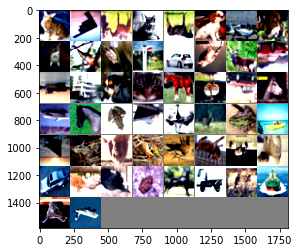

  cat plane horse   cat horse   dog plane  frog   cat  bird  bird  ship   car  bird  deer   car  ship  ship   dog   cat horse  bird   car horse  ship horse  frog  ship  bird  deer  frog  ship  ship  frog   dog  frog  deer   dog  deer   dog   car  deer   cat  frog horse truck  deer  ship  bird plane


In [6]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(50)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


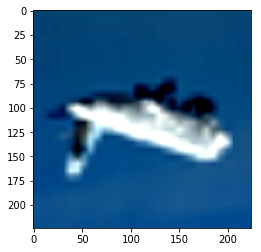

In [7]:
imshow(images[49])

In [8]:
len(train_loader)

1000

In [9]:
val_data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435, 0.2616))
])
val_set = torchvision.datasets.CIFAR10(root='./data',
                                      train=False, download=True,
                                      transform=val_data_transform)
val_order = torch.utils.data.DataLoader(val_set,
                                        
                                        batch_size=batch_size,
                                        shuffle=False, num_workers=2
                                       )

Files already downloaded and verified


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
def train_model(model, loss_function, optimizer, data_loader):
    overall_start = timer()
    # set the model mode
 #   model.train()
    for epoch in range(n_epochs):
        current_acc = 0
        current_loss =0
        model.train()
        start = timer()
        
    
    # iterate over the examples in the dataset:
        for i, (inputs, labels) in enumerate(data_loader):
        # send them to the GPU first
            inputs = inputs.to(device)
            labels = labels.to(device)
        
        # zero the parameter gradients
            optimizer.zero_grad()
        
            with torch.set_grad_enabled(True):
            # forward
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                loss = loss_function(outputs, labels)
            
            # backward
                loss.backward()
                optimizer.step()
            
            # statistics
            current_loss += loss.item() * inputs.size(0)
            current_acc += torch.sum(predictions == labels.data)
        
        total_loss = current_loss / len(data_loader.dataset)
        total_acc = current_acc.double() / len(data_loader.dataset)
    
        print('Train Loss: {:.4f}; Accuracy {:.4f}'.format(total_loss, total_acc))

In [12]:
def test_model(model, loss_function, data_loader):
    # set model in evaluation mode
    model.eval()
    
    current_loss = 0.0
    current_acc = 0
    
    # iterate over the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)
            
        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)
        
    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double()/ len(data_loader.dataset)
    
    print('Test Loss: {:.4f}; Accuracy {:.4f}'.format(total_loss, total_acc))
    
    return total_loss, total_acc
    
    

Now, onto the transfer learning scenario where we are going to use the pretrained network as a feature extractor.
1. Let's use ResNet50
2. Replace last layer of the model with a new layer with 10 outputs
3. Exclude the existing network layers from the backward pass and only pass the newly added fully-connected layer to the Adam optimizer.
4. Run the training for epochs and evaluate the network accuracy after each epoch.
5. Plot the test accuracy

# Load Resnet50

In [15]:
model = torchvision.models.resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [ ]:
def train(model, criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs = 20,
          print_every=2):
    """Train the Pytorch model while including the """

In [14]:
def tl_feature_extractor(epochs=5):
    # load the pretrained model
    model = torchvision.models.resnet50(pretrained=True)
    
    # exclude the existing parameters from backward pass
    # for performance
    for param in model.parameters():
        param.requires_grad = False
        
    # newly constructed layers have requires_grad=True by default
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
                nn.Linear(num_features, 1000),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(1000, 10),
                nn.LogSoftmax(dim=1))
#    model.fc = nn.Linear(1000, 10)
    
    # transfer to GPU
    model = model.to(device)
    
    loss_function = nn.CrossEntropyLoss()
    
    # only parameters of the final layer are being optimized
    optimizer = optim.Adam(model.fc.parameters())    # otherwise, it would be just model.parameters()
    
    # setting timing
    overall_start = timer()
    # train
    test_acc = list()
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        
        train_model(model, loss_function, optimizer, train_loader)
        _, acc = test_model(model, loss_function, val_order)
        test_acc.append(acc)
    
    plot_accuracy(test_acc)

In [ ]:
tl_feature_extractor()

Epoch 1/5
